
## ASWO-OP10-ICON global


uses envs/env_clouds.yml


ICON global data needs to be regridded:
https://opendata.dwd.de/weather/nwp/icon/grib/00/clct/

uses cdo to convert to regular grid, need to "brew install cdo"
https://code.mpimet.mpg.de/projects/cdo/wiki/MacOS_Platform

need to download the grid definition file from 
https://opendata.dwd.de/weather/lib/cdo/



In [71]:
from datetime import datetime
from datetime import timedelta
import metview as mv
import eccodes
import requests
import xarray
import numpy
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as carfeat
import os
import pickle
import urllib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors


from auroramaps import util as au

print(cartopy.__version__)

%matplotlib inline
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


#make sure to convert the current notebook to a script
os.system('jupyter nbconvert op_cloud.ipynb  --to script')   
icon_path='data/icon/'

#file needed for grid conversion
filegrid=icon_path+'gridfiles/icon_grid_0026_R03B07_G.nc'



0.24.1


[NbConvertApp] Converting notebook op_cloud.ipynb to script
[NbConvertApp] Writing 9053 bytes to op_cloud.py


In [21]:

#if new background images need to be saved in auroramaps/data/wmts do this, some are included!
#au.save_gibs_earth_image('BlueMarble_NextGeneration',300)    
#au.save_gibs_earth_image('VIIRS_CityLights_2012',300)    
#au.save_gibs_earth_image('BlueMarble_NextGeneration',600)    
#au.save_gibs_earth_image('VIIRS_CityLights_2012',600)    

#background image for maps
map_type='marble'
map_img=au.load_high_res_background(map_type)


#read in ovation test data
wic=pickle.load(open('data/ovation_img_test_1.p', 'rb') )


#aurora
def flux_cmap():
    # Define the colors for the colormap    
    colors = [
            (0.0, 'black'),   # Black at 0 and below
            (0.1, 'green'),   # Green at 0.1
            (0.7, 'yellow'),  # Yellow at 0.5
            (1.0, 'red')      # Red at 1
        ]
    #Create the colormap
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom_colormap', colors,N=256)
    #cmap.set_under(color='black', alpha=0)

    my_cmap = cmap(np.arange(cmap.N))  # Get the colormap colors
    #set lowest 10 color alphas to 0
    my_cmap[0:20, -1]=0
    cmap = ListedColormap(my_cmap) # Create new colormap
    

    return cmap

cmap = plt.get_cmap('hot')  # Choose colormap
my_cmap = cmap(np.arange(cmap.N))  # Get the colormap colors
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)  #************ Set alpha
my_cmap = ListedColormap(my_cmap) # Create new colormap


In [39]:
#total cloud cover

#### download a latest cloud cover file

#example
#https://opendata.dwd.de/weather/nwp/icon/grib/00/clct/icon_global_icosahedral_single-level_2025041000_000_CLCT.grib2

#check definitions
run='06'
hours_ahead='006' #always with zero
# Get today's date and create the appropriate format
today_run = datetime.utcnow().strftime("%Y%m%d")+run
print(run, hours_ahead, today_run)

fileicon='icon_global_icosahedral_single-level_'+today_run+'_'+hours_ahead+'_CLCT.grib2.bz2'
url = 'https://opendata.dwd.de/weather/nwp/icon/grib/'+run+'/clct/'+fileicon
fileicon_disk=icon_path+fileicon

print(fileicon_disk)

print(url)
print()
print('download latest ICON global cloud cover file as:')
print(fileicon_disk)
print()

#if file not there already, download:
if os.path.exists(fileicon_disk): print('File already here')

if os.path.exists(fileicon_disk)==False:
    try: 
        urllib.request.urlretrieve(url,fileicon_disk)
        os.system('bzip2 -d '+fileicon_disk)
    except urllib.error.URLError as e:
        print('not downloaded')

#decompressed file
fileicon_disk_d=icon_path+'icon_global_icosahedral_single-level_'+today_run+'_'+hours_ahead+'_CLCT.grib2'
#read in file

print('file downloaded and decompressed')

06 006 2025041006
data/icon/icon_global_icosahedral_single-level_2025041006_006_CLCT.grib2.bz2
https://opendata.dwd.de/weather/nwp/icon/grib/06/clct/icon_global_icosahedral_single-level_2025041006_006_CLCT.grib2.bz2

download latest ICON global cloud cover file as:
data/icon/icon_global_icosahedral_single-level_2025041006_006_CLCT.grib2.bz2

File already here
file downloaded and decompressed


In [40]:
print(fileicon_disk)
print(fileicon_disk_d)


data/icon/icon_global_icosahedral_single-level_2025041006_006_CLCT.grib2.bz2
data/icon/icon_global_icosahedral_single-level_2025041006_006_CLCT.grib2


In [50]:
#convert to regular grid
#fileicon=icon_path+'icon_global_icosahedral_single-level_2025040500_180_CLCT.grib2'

#converted file to lat lon grid will be named:
#fileiconc=icon_path+'icon_global_icosahedral_single-level_2025040500_180_CLCT_conv.grib2'

#cdo remapcon,r720x360 -setgrid,icon_grid_0026_R03B07_G.nc icon_data.grib output_latlon.grib

# For a global 0.25° grid
#cdo remapcon,r1440x720 icon_data.grib output_latlon.grib

# For a global 0.5° grid
#cdo remapcon,r720x360 icon_data.grib output_latlon.grib

# For a global 1.0° grid
#cdo remapcon,r360x180 icon_data.grib output_latlon.grib


fileconv=fileicon_disk_d+'.conv'

#0.25 grid
#os.system('cdo remapcon,r1440x720 -setgrid,'+filegrid+' '+fileicon_disk_d+' '+fileconv)

#0.125 grid
os.system('cdo remapcon,r2880x1440 -setgrid,'+filegrid+' '+fileicon_disk_d+' '+fileconv)


print()
print('file grid converted')

cdo    remapcon: YAC first order conservative weights from unstructured (2949120) to lonlat (2880x1440) grid

file grid converted


ECCODES ERROR   :  pack_bytes: Wrong size (20) for section2Padding. It is 0 bytes long


(4147200,)


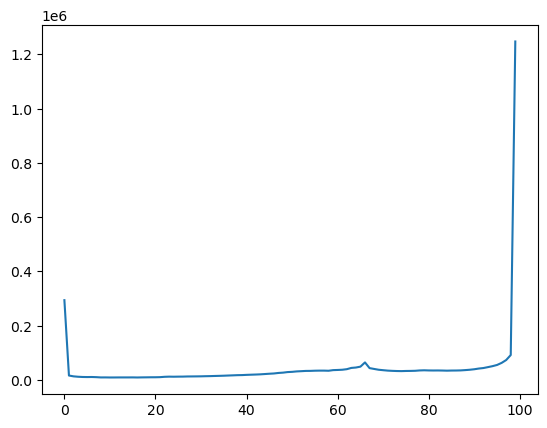

In [68]:
## read data from converted file
data = mv.read(fileconv)
data.ls()
data.describe()
lats, lons = mv.latitudes(data), mv.longitudes(data)
values = mv.values(data)

lats.shape
lons.shape
print(values.shape)


hist, bin_edges = np.histogram(values, bins=100)
plt.plot(hist)



In [ ]:
#read time
time_info = mv.grib_get(data, ['dataDate', 'dataTime','stepRange'])

#run at dataDate and dataTime is valid stepRange into the future, so construct time for forecast like this:
time_run_str=time_info[0][0][0:4]+'-'+time_info[0][0][4:6]+'-'+time_info[0][0][6:8]+' '+time_info[0][1][0:2]+':'+time_info[0][1][2:4]
date_format = "%Y-%m-%d %H:%M"
time_run=datetime.strptime(time_run_str, date_format)
print('time of run',time_run)

#add step time to run time
time_lead=int(time_info[0][2])
print('forecast lead time:',time_lead, 'hours')

time_icon=time_run+timedelta(hours=int(time_info[0][2]))
print('time valid for forecast:',time_icon)
print()

In [89]:
def create_cloud_cmap(response_function="linear", gamma=2.0,alphatop=0.5):
    """
    Create a cloud colormap from transparent to white with a custom response function.
    
    Parameters:
    -----------
    response_function : str
        Type of response function: "linear", "gamma", "sigmoid", or "quadratic"
    gamma : float
        Parameter for gamma correction (used when response_function="gamma")
    
    Returns:
    --------
    matplotlib.colors.LinearSegmentedColormap
        Custom cloud colormap
    """
    # Create N sample points for our functions
    N = 256
    x = np.linspace(0, alphatop, N)
    
    # Apply the response function to control transparency
    if response_function == "linear":
        alpha = x  # Linear response (default)
    elif response_function == "gamma":
        alpha = x ** gamma  # Gamma correction
    elif response_function == "sigmoid":
        alpha = 1 / (1 + np.exp(-10 * (x - 0.5)))  # Sigmoid function
    elif response_function == "quadratic":
        alpha = x ** 2  # Quadratic response
    else:
        raise ValueError(f"Unknown response function: {response_function}")
    # Create the colormap with white RGB and variable alpha
    colors = [(1, 1, 1, a) for a in alpha]
    #print(alpha[-1])
    
    
    return LinearSegmentedColormap.from_list(f'cloud_{response_function}', colors)

# Create and register several cloud colormaps with different response functions
#cloud_linear = create_cloud_cmap("linear")
#cloud_sigmoid = create_cloud_cmap("sigmoid")
#cloud_quadratic = create_cloud_cmap("quadratic")




#---------- cloud data
#test with colormap
#colors = [(1,1,1,c) for c in np.linspace(0,1,100)]
#cmap1 = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)




In [ ]:
# Create a figure and axis with Cartopy projection

####### change parameters

region='global'
#region='europe'


view_latitude=45
view_longitude=10
#map_type='topography'
map_type='marble'



#these are fixed
plot_pos=[0.05,0.05,0.9,0.9]
global_mapextent=[-180,180,-90,90]



####### cartopy figure

fig = plt.figure(figsize=(20, 10),dpi=200)
fig.set_facecolor('black') 
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(view_longitude, view_latitude),position=plot_pos)

crs=ccrs.PlateCarree()
map_img=au.load_high_res_background(map_type)


##### borders and coasts parameters depending on background image
if map_type=='marble': bordercolor='black'; borderalpha=0.4; coastcolor='black';coastalpha=0.4
if map_type=='viirs':  bordercolor='white'; borderalpha=0.5; coastcolor='white';coastalpha=0.3
if map_type=='topography': bordercolor='black'; borderalpha=0.4; coastcolor='black';coastalpha=0.1

#get high res country borders  
#https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
borders_10m = carfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', facecolor='none',edgecolor=bordercolor)
ax.add_feature(borders_10m,alpha=borderalpha, zorder=3)
#add coastlines
ax.coastlines('10m', color=coastcolor,alpha=coastalpha, zorder=3)



#get high res state borders
#provinces_50m = carfeat.NaturalEarthFeature('cultural','admin_1_states_provinces_lines','50m',facecolor='none',edgecolor=bordercolor)
#ax.add_feature(provinces_50m,alpha=borderalpha)

if region == 'europe': 
     #europe_east = 40; europe_west = -25; europe_north = 75; europe_south = 30 
     #europe_east = 30; europe_west = -9; europe_north = 68;  europe_south = 35 
     europe_east = 40; europe_west = -30; europe_north = 75;  europe_south = 30      
     ax.set_extent([europe_west, europe_east, europe_south, europe_north])



#--------- background
ax.imshow(map_img,origin='upper',transform=crs, extent=global_mapextent)

#------------- aurora
min_level=0
max_level=5

#cmap = plt.get_cmap('hot')
#or use my_cmap
ax.imshow(wic[:,:,5], vmin=min_level, vmax=max_level, transform=crs, extent=global_mapextent, origin='lower', zorder=3,alpha=0.9, cmap=my_cmap) 



##check why this works better or worse, depends also on grid 0125 or 025, maybe redo with markersize or grid for global
# global / europe need different settings depending on resolution

if region=='global':
    alpha=0.07
    cmap1 = LinearSegmentedColormap.from_list('transparent_to_white', [(1, 1, 1, 0), (1, 1, 1, alpha)], N=20)
    ax.scatter(lons, lats, c=values, cmap=cmap1, transform=crs,zorder=2)

if region=='europe':
    cloud_gamma = create_cloud_cmap("gamma", gamma=6.0,alphatop=0.7)
    ax.scatter(lons, lats, c=values, cmap=cloud_gamma, transform=crs,zorder=2)




#check size matters? depends on map extent and grid resolution; better to NOT specify marker size
#size=20
#ax.scatter(lons, lats, c=values, cmap=cmap1, s=size,transform=crs,zorder=2)

# Add a colorbar
#plt.colorbar(sc, orientation='horizontal', pad=0.05, aspect=50)

# Add a title
plt.title('ICON total cloud cover, Ovation Prime 2010, cartopy ' +str(time_icon)[0:16],color='white')

plt.savefig('results/clouds/icon/'+region+'_icon.png', format='png', bbox_inches='tight')

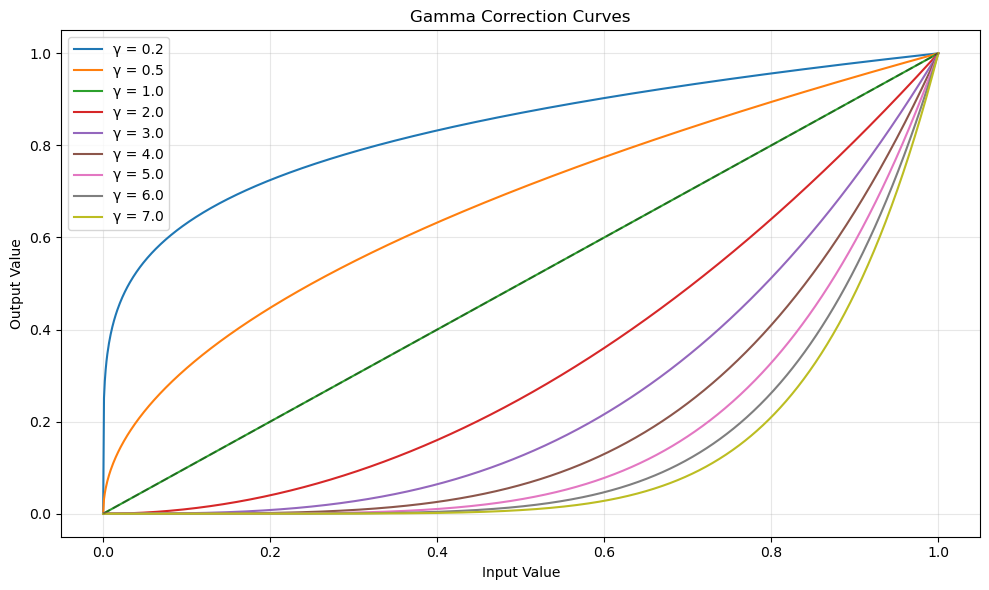

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample points
x = np.linspace(0, 1, 1000)

# Create several gamma curves
gamma_values = [0.2, 0.5, 1.0, 2.0,3.0,4.0, 5.0,6.0,7.0]
gamma_curves = [x**gamma for gamma in gamma_values]

# Plot the curves
plt.figure(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    plt.plot(x, gamma_curves[i], label=f'γ = {gamma}')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Linear reference line
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.title('Gamma Correction Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()